In [ ]:
!pip install krippendorff matplotlib pandas spacy tqdm
!spacy download en_core_web_sm

In [ ]:
from glob import glob
import json
import lzma
import math
import os

import krippendorff
import numpy as np
import pandas as pd
import spacy
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Helvetica LT Pro', 'Helvetica', 'Arial', 'DejaVu Sans']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams["legend.edgecolor"] = 'lightgray'
plt.rcParams["legend.framealpha"] = 1.0
plt.rcParams["legend.fancybox"] = False

In [3]:
# Read ground truth annotations
y_test_goldstandard = []
for d in tqdm(glob(os.path.join('data', 'youtube-dev-set-annotated-*.csv')), desc='Loading truth labels'):
    y_test_goldstandard.append(pd.read_csv(d, names=['url', 'label'], index_col=0))

y_test_goldstandard = pd.concat(y_test_goldstandard)
y_test_goldstandard = y_test_goldstandard.groupby(y_test_goldstandard.index)

# Agreement
alpha = krippendorff.alpha(reliability_data=y_test_goldstandard['label'].apply(
    lambda x: pd.Series(x.values)).unstack().transpose())
print(f'Agreement (Krippendorff\'s α): {alpha:.2f}')

# Use majority vote
y_test_goldstandard = y_test_goldstandard.mean().round()
print(f'Non-Spam: {int(y_test_goldstandard.sum())} ({float(y_test_goldstandard.sum() / len(y_test_goldstandard)):.1%})')
print(f'Spam: {int(len(y_test_goldstandard) - y_test_goldstandard.sum())}')

Loading truth labels: 100%|██████████| 3/3 [00:00<00:00, 273.84it/s]

Agreement (Krippendorff's α): 0.87
Non-Spam: 130 (65.0%)
Spam: 70


In [4]:
urls = {}
word_tokens = []
pos_tokens = []
result_cutoff = 20
result_ranks = []
num_loaded = []

try:
    for f in glob(os.path.join('data', 'youtube-transcripts-*.jsonl.xz')):
        num_loaded.append(0)
        for l in tqdm(lzma.open(f, 'r'), desc='Loading transcripts'):
            transcript = json.loads(l)
            if transcript['url'] in urls or transcript['hit'] > result_cutoff:
                continue

            result_ranks.append(transcript['hit'])
            music_count = sum(1 if t['text'] == '[Music]' else 0 for t in transcript['transcript'])
            text = ' '.join(t['text'] for t in transcript['transcript'] if t['text'] != '[Music]')
            doc = nlp(text, disable=['parser', 'ner', 'lemmatizer', 'textcat'])

            tags = [t.tag_ for t in doc if t.tag_.strip()]
            if len(tags) < 100 or music_count > len(tags):
                continue

            num_loaded[-1] += 1
            urls[transcript['url']] = True
            pos_tokens.append(tags)
            word_tokens.append([t.text for t in doc])
finally:
    urls = list(urls.keys())
    print('Transcripts loaded:', ', '.join(map(str, num_loaded)))

Loading transcripts: 979it [01:05, 14.94it/s]
Loading transcripts: 529it [00:17, 30.64it/s]
Loading transcripts: 4676it [06:40, 11.68it/s]

Transcripts loaded: 686, 190, 3879


In [5]:
result_ranks = np.array(result_ranks)
print('Video rank (counting from 1):\n')

print(f'Average @20: {np.average(result_ranks + 1):.1f}')
print(f'Median @20: {np.median(result_ranks + 1):.1f}')
print(f'Num @20: {len(result_ranks + 1)}')
print(f'\nAverage @10: {np.average(result_ranks[result_ranks < 10] + 1):.1f}')
print(f'Median @10: {np.median(result_ranks[result_ranks < 10] + 1):.1f}')
print(f'Num @10: {len(result_ranks[result_ranks < 10] + 1)}')

print(f'\nPortion of videos @10: {len(result_ranks[result_ranks < 10] + 1) / len(result_ranks + 1):.1f}')

Video rank (counting from 1):

Average @20: 10.5
Median @20: 10.0
Num @20: 5038

Average @10: 6.1
Median @10: 6.0
Num @10: 2595

Portion of videos @10: 0.5


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

def _ngrams(t, n):
    return [' '.join(t[i:i+n]) for i in range(len(t) - n)]

def _analyzer(t):
    return t + _ngrams(t, 2) + _ngrams(t, 3) + _ngrams(t, 4)

pos_vectorizer = CountVectorizer(analyzer=_analyzer, max_features=150)
pos_count_matrix = pos_vectorizer.fit_transform(pos_tokens)
X = normalize(pos_count_matrix.toarray(), norm='l1', axis=1)

X_train = []
X_test = []
y_true = []
urls_train = []
urls_test = []

for i in range(X.shape[0]):
    if urls[i] in y_test_goldstandard.index:
        X_test.append(X[i])
        urls_test.append(urls[i])
        y_true.append(y_test_goldstandard.loc[urls[i]]['label'])
    else:
        X_train.append(X[i])
        urls_train.append(urls[i])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_true = np.array(y_true)

In [7]:
pos_freqs = np.array(pos_count_matrix.sum(axis=0)).flatten()
print('POS n-grams by frequency:')
print([p[0].replace(' ', '+') for p in sorted(pos_vectorizer.vocabulary_.items(), key=lambda x: pos_freqs[x[1]], reverse=True)])

POS n-grams by frequency:
['NN', 'IN', 'DT', 'PRP', 'RB', 'JJ', 'VB', 'DT+NN', 'NNS', 'VBZ', 'VBP', 'CC', 'IN+DT', 'NN+IN', 'JJ+NN', 'PRP+VBP', 'NN+NN', 'DT+JJ', 'VBG', 'TO', 'CD', 'IN+DT+NN', 'NNP', 'TO+VB', 'IN+PRP', 'MD', 'VBN', 'DT+JJ+NN', 'NN+CC', 'PRP$', 'RB+RB', 'PRP+VBZ', 'VBD', 'VB+DT', 'IN+NN', 'DT+NN+IN', 'MD+VB', 'NN+IN+DT', 'PRP+MD', 'NNS+IN', 'NN+VBZ', 'NN+PRP', 'VBZ+DT', 'RB+VB', 'NN+RB', 'WDT', 'RB+IN', '_SP', 'UH', 'RB+JJ', 'JJ+NNS', 'RP', 'PRP+MD+VB', 'VBZ+RB', 'VB+PRP', 'NN+NNS', 'DT+NN+NN', 'CC+PRP', 'PRP$+NN', 'VBP+RB', 'VB+IN', 'IN+DT+JJ', 'JJ+NN+IN', 'IN+PRP+VBP', 'DT+NNS', 'RB+PRP', 'JJ+IN', 'VBP+DT', 'NN+IN+DT+NN', 'IN+PRP$', 'NN+DT', 'PRP+RB', 'NNS+CC', 'PRP+VBD', 'IN+JJ', 'VB+DT+NN', 'WRB', '.', 'RB+DT', 'JJ+NN+NN', 'CC+DT', 'VBN+IN', 'JJ+JJ', 'VBP+VBG', 'PRP+VBP+RB', 'DT+VBZ', 'JJR', 'NN+WDT', 'CD+NNS', 'CC+RB', 'PRP+VBP+VBG', 'TO+VB+DT', 'NN+NN+NN', 'NN+IN+NN', 'NNP+NNP', 'CD+NN', 'IN+DT+JJ+NN', 'IN+DT+NN+IN', 'VBG+TO', 'NN+IN+PRP', ',', 'VBG+TO+VB', 'NN+NN

In [8]:
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE

n_clusters = 2
y_train = SpectralClustering(n_clusters=n_clusters).fit_predict(X_train)
# Clustering my inadvertently swap labels
if np.sum(y_train) / y_train.shape[0] < 0.5:
    y_train = 1 - y_train

print(f'Non-Spam: {np.sum(y_train)} ({np.sum(y_train) / len(y_train):.2%})')
print(f'Spam: {y_train.shape[0] - np.sum(y_train)}')

Non-Spam: 2353 (51.66%)
Spam: 2202


In [9]:
X_3d = TSNE(n_components=3, random_state=29, init='random', method='barnes_hut', n_jobs=-1).fit_transform(np.vstack((X_train, X_test)))
X_train_3d = X_3d[:X_train.shape[0], :]
X_test_3d = X_3d[X_train.shape[0]:, :]

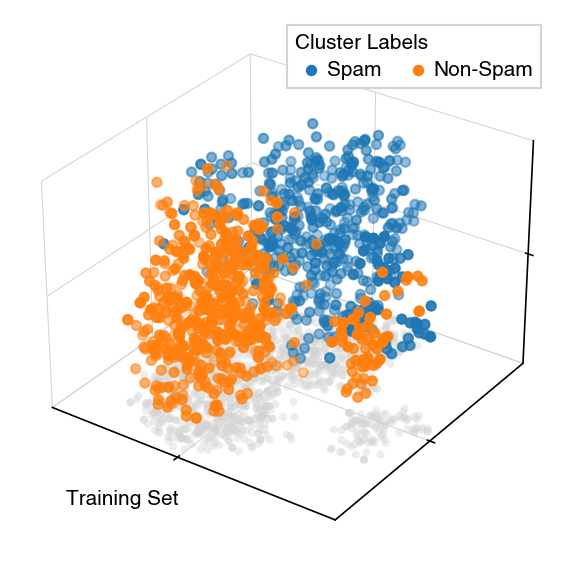

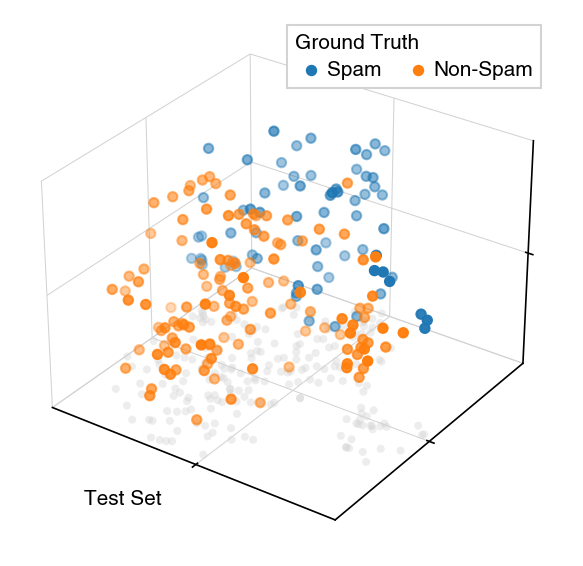

In [10]:
def _ceil10(n):
    return int(math.ceil(n / 10) * 10)

def _floor10(n):
    return int(math.floor(n / 10) * 10)

def _config_axis(ax, data):
    ax.set_ticks(np.linspace(_floor10(np.min(data)), _ceil10(np.max(data)), 3))
    ax.set_ticklabels([])
    ax.pane.fill = False
    ax.pane.set_linewidth(0.5)
    ax.pane.set_alpha(1.0)
    ax.pane.set_edgecolor(plt.rcParams['grid.color'])

def _plot_scatter(X_3d, y, title, legend_title, outfile=None, subsample=1.0):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(projection='3d', computed_zorder=True)
    ax.view_init(30, 125, 0)

    if subsample < 1.0:
        sampler = np.random.choice(X_3d.shape[0], int(X_3d.shape[0] * subsample))
        X_3d_sampled = X_3d[sampler]
        y_sampled = y[sampler]
    else:
        X_3d_sampled = X_3d
        y_sampled = y

    labels = ['Spam', 'Non-Spam']
    for i in range(len(labels)):
        scatter_data = X_3d_sampled[y_sampled == i]
        ax.scatter(scatter_data[:, 0], scatter_data[:, 1], scatter_data[:, 2], label=f'{labels[i]}')

    scatter_data_projected = np.array(X_3d_sampled)
    scatter_data_projected[:, 2] = np.min(scatter_data_projected[:, 2])
    ax.scatter(scatter_data_projected[:, 0], scatter_data_projected[:, 1], scatter_data_projected[:, 2], c='lightgray', s=15, lw=0, alpha=0.4)

    _config_axis(ax.axes.xaxis, X_3d[:, 0])
    _config_axis(ax.axes.yaxis, X_3d[:, 1])
    _config_axis(ax.axes.zaxis, X_3d[:, 2])
    ax.axes.margins(0, 0, 0, tight=False)

    plt.legend(labelspacing=0.4, handletextpad=0, ncols=2, columnspacing=1.0, handlelength=1.5, title=legend_title, alignment='left')
    plt.title(title, y=0.07, x=0.2, fontdict=dict(fontsize=10))
    fig.canvas.draw()
    plt.tight_layout()
    if outfile:
        fig.savefig(outfile)
    plt.show()

_plot_scatter(X_train_3d, y_train, 'Training Set', 'Cluster Labels', os.path.join('data', 'youtube-scatter-clusters.pdf'), .25)
_plot_scatter(X_test_3d, y_true, 'Test Set', 'Ground Truth', os.path.join('data', 'youtube-scatter-truth.pdf'))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

for clf in [LogisticRegression(), LinearSVC(dual='auto')]:
    print(f'{clf.__class__.__name__}:\n-----')
    
    clf.fit(X_train[y_train > -1], y_train[y_train > -1])
    y_pred = clf.predict(X_test)
    y_scores = clf.decision_function(X_test) if hasattr(clf, 'decision_function') else None
    
    # Trivial classifiers
    # y_pred = X_test[:, pos_vectorizer.vocabulary_['NN']] < 0.1
    # y_pred = X_test[:, pos_vectorizer.vocabulary_['PRP']] > 0.035
    
    print(f'Accuracy (balanced): {balanced_accuracy_score(y_true, y_pred):.2f}')
    if y_scores is not None:
        print(f'AUROC: {roc_auc_score(y_true, y_scores):.2f}')
    
    print('\nNon-Spam:')
    print(f'Precision: {precision_score(y_true, y_pred):.2f}')
    print(f'Recall: {recall_score(y_true, y_pred):.2f}')
    print(f'F1: {f1_score(y_true, y_pred):.2f}')
    
    print('\nSpam:')
    print(f'Precision: {precision_score(y_true, y_pred, pos_label=0):.2f}')
    print(f'Recall: {recall_score(y_true, y_pred, pos_label=0):.2f}')
    print(f'F1: {f1_score(y_true, y_pred, pos_label=0):.2f}\n\n')

LogisticRegression:
-----
Accuracy (balanced): 0.90
AUROC: 0.95

Non-Spam:
Precision: 0.99
Recall: 0.82
F1: 0.89

Spam:
Precision: 0.74
Recall: 0.99
F1: 0.85


LinearSVC:
-----
Accuracy (balanced): 0.89
AUROC: 0.95

Non-Spam:
Precision: 1.00
Recall: 0.78
F1: 0.88

Spam:
Precision: 0.71
Recall: 1.00
F1: 0.83


In [12]:
display(pd.DataFrame(zip(urls_test, y_pred), columns=['url', 'label']).sort_values(by=['label']))

,url,label
0,https://www.youtube.com/watch?v=MXIovhY5xHU,0
94,https://www.youtube.com/watch?v=OOO4N7AHBDg,0
93,https://www.youtube.com/watch?v=4Ks2tXdRwQM,0
91,https://www.youtube.com/watch?v=QFWwD8uH5-Y,0
87,https://www.youtube.com/watch?v=evU4LQNlhVA,0
86,https://www.youtube.com/watch?v=c392JGmMNmI,0
85,https://www.youtube.com/watch?v=d2f2J_hcBwE,0
83,https://www.youtube.com/watch?v=gYucSC8hhNU,0
82,https://www.youtube.com/watch?v=Em9909eHYKw,0
81,https://www.youtube.com/watch?v=EbKaHPrcbAM,0


POS n-grams by importance:
['NN', 'PRP', 'RB', 'JJ', 'PRP+VBP', 'VBP', 'NN+NN', 'NNS', 'JJ+NN', 'CD', 'RB+RB', 'IN+PRP', 'NNP', 'NN+VBZ', 'VBN', 'CC+PRP', 'UH', 'VBD', 'NN+NNS', 'VB', 'VBN+IN', 'VBP+VBG', 'VBG+TO', 'RB+PRP', 'NN+NN+NN', 'PRP+VBD', 'NN+IN', 'VBG+TO+VB', 'PRP+VBP+VBG', 'IN+NN', 'IN+JJ', 'VBZ', 'JJ+NN+NN', 'VBP+RB', 'IN', 'NNS+IN', 'PRP+VBP+RB', 'HYPH', 'DT+VBZ', 'JJ+NNS', 'VB+PRP', 'PRP+RB', 'NNP+NNP', 'DT', 'PRP+MD', 'NN+DT', 'IN+PRP+VBP', 'DT+JJ', 'RP', 'RB+IN', 'PRP$', 'VBZ+DT', 'PRP+MD+VB', 'VBG', 'NN+RB', 'CC+RB', 'VBZ+JJ', 'NN+PRP+VBP', 'RB+PRP+VBP', 'JJS', 'IN+CD', 'WRB', 'RB+JJ', 'CC+NN', 'DT+NN+NN', 'NN+PRP', 'CD+NNS', 'CD+NN', 'RB+DT', 'JJ+JJ', 'WP', 'NN+NN+IN', 'IN+VBG', 'NNP+NN', 'NNS+VBP', 'WRB+PRP', 'DT+NNP', 'TO+VB', 'VBZ+DT+JJ', 'VBP+PRP', 'DT+NN+VBZ', 'VBZ+RB', 'JJ+NN+IN', 'PRP+VBP+DT', 'VB+DT', 'JJ+IN', 'DT+JJ+NN', 'NN+JJ', 'CC', 'TO', 'PRP$+NN', 'NNS+IN+DT', 'NN+IN+NN', 'DT+NN+PRP', 'DT+NN+CC', 'RB+IN+DT', 'DT+NN+RB', 'IN+PRP$', 'NNS+CC', 'DT+NN+IN', '

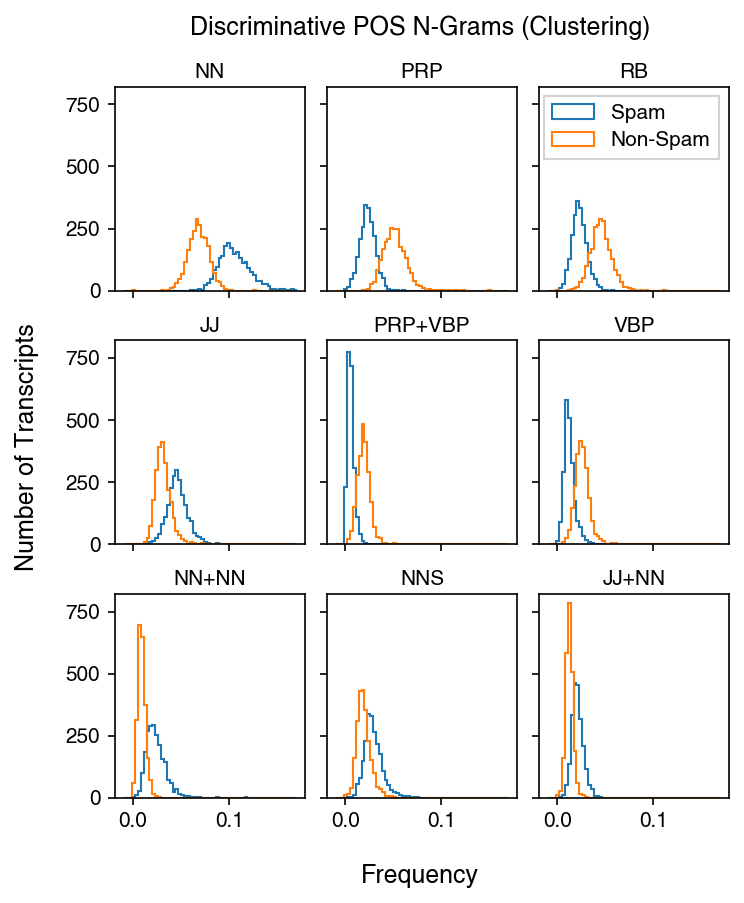

POS n-grams by importance:
['NN', 'PRP', 'RB', 'JJ', 'PRP+VBP', 'VBP', 'NN+NN', 'NNS', 'JJ+NN', 'CD', 'RB+RB', 'IN+PRP', 'NNP', 'NN+VBZ', 'VBN', 'CC+PRP', 'UH', 'VBD', 'NN+NNS', 'VB', 'VBN+IN', 'VBP+VBG', 'VBG+TO', 'RB+PRP', 'NN+NN+NN', 'PRP+VBD', 'NN+IN', 'VBG+TO+VB', 'PRP+VBP+VBG', 'IN+NN', 'IN+JJ', 'VBZ', 'JJ+NN+NN', 'VBP+RB', 'IN', 'NNS+IN', 'PRP+VBP+RB', 'HYPH', 'DT+VBZ', 'JJ+NNS', 'VB+PRP', 'PRP+RB', 'NNP+NNP', 'DT', 'PRP+MD', 'NN+DT', 'IN+PRP+VBP', 'DT+JJ', 'RP', 'RB+IN', 'PRP$', 'VBZ+DT', 'PRP+MD+VB', 'VBG', 'NN+RB', 'CC+RB', 'VBZ+JJ', 'NN+PRP+VBP', 'RB+PRP+VBP', 'JJS', 'IN+CD', 'WRB', 'RB+JJ', 'CC+NN', 'DT+NN+NN', 'NN+PRP', 'CD+NNS', 'CD+NN', 'RB+DT', 'JJ+JJ', 'WP', 'NN+NN+IN', 'IN+VBG', 'NNP+NN', 'NNS+VBP', 'WRB+PRP', 'DT+NNP', 'TO+VB', 'VBZ+DT+JJ', 'VBP+PRP', 'DT+NN+VBZ', 'VBZ+RB', 'JJ+NN+IN', 'PRP+VBP+DT', 'VB+DT', 'JJ+IN', 'DT+JJ+NN', 'NN+JJ', 'CC', 'TO', 'PRP$+NN', 'NNS+IN+DT', 'NN+IN+NN', 'DT+NN+PRP', 'DT+NN+CC', 'RB+IN+DT', 'DT+NN+RB', 'IN+PRP$', 'NNS+CC', 'DT+NN+IN', '

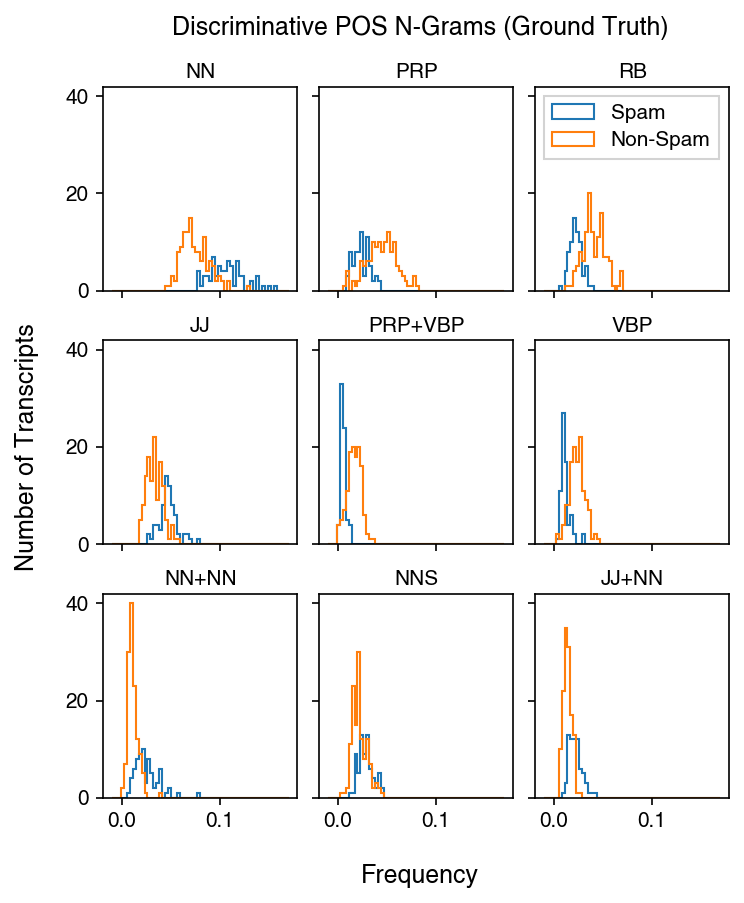

In [13]:
def _plot_top_ngrams(X, y, coef, title, outfile=None):
    # coef_argsorted = np.argsort(coef)
    # coef_argsorted = np.argsort(coef)[::-1]
    coef_argsorted = np.argsort(np.abs(coef))[::-1]
    ngrams_sorted = [k.replace(' ', '+') for k, _ in sorted(pos_vectorizer.vocabulary_.items(), key=lambda i: i[1])]
    print('POS n-grams by importance:')
    print([ngrams_sorted[coef_argsorted[i]] for i in range(len(ngrams_sorted))])

    fig, axs = plt.subplots(3, 3, sharex='all', sharey='all', figsize=(5, 6))
    for i, ax in enumerate(axs.flatten()):
        for c, label in enumerate(['Spam', 'Non-Spam']):
            ax.hist(X[y == c, coef_argsorted[i]], label=label, bins=np.arange(-0.01, 0.17, 0.003), histtype='step')
        ax.set_xlabel(ngrams_sorted[coef_argsorted[i]])
        ax.xaxis.set_label_position('top')

    fig.supxlabel('Frequency', x=0.56)
    fig.supylabel('Number of Transcripts')
    lines, labels = axs[0, 0].get_legend_handles_labels()
    plt.figlegend(lines, labels, loc='upper right', bbox_to_anchor=(0.972, 0.902), ncol=1, labelspacing=0.4)
    plt.suptitle(title, x=0.56)
    plt.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)
    if outfile:
        fig.savefig(outfile)
    plt.show()

_plot_top_ngrams(X_train, y_train, clf.coef_[0], 'Discriminative POS N-Grams (Clustering)', os.path.join('data', 'youtube-pos-ngrams-cluster.pdf'))
_plot_top_ngrams(X_test, y_true, clf.coef_[0], 'Discriminative POS N-Grams (Ground Truth)', os.path.join('data', 'youtube-pos-ngrams-truth.pdf'))